In [52]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from autosklearn.experimental.askl2 import AutoSklearn2Classifier, AutoSklearnClassifier
from autosklearn.pipeline.classification import BasePipeline

In [3]:
with open('data/train.jsonl') as f:
    train_data = pd.read_json(f, lines=True)

In [4]:
train_data.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


In [5]:
with open('data/test.jsonl') as f:
    test_data = pd.read_json(f, lines=True)

In [6]:
test_data.head()

,id,response,context
0,twitter_1,"@USER @USER @USER My 3 year old , that just fi...","[Well now that ’ s problematic AF <URL>, @USER..."
1,twitter_2,@USER @USER How many verifiable lies has he to...,[Last week the Fake News said that a section o...
2,twitter_3,@USER @USER @USER Maybe Docs just a scrub of a...,[@USER Let ’ s Aplaud Brett When he deserves i...
3,twitter_4,@USER @USER is just a cover up for the real ha...,[Women generally hate this president . What's ...
4,twitter_5,@USER @USER @USER The irony being that he even...,"[Dear media Remoaners , you excitedly sharing ..."


In [7]:
train_data['label'].value_counts()

SARCASM        2500
NOT_SARCASM    2500
Name: label, dtype: int64

In [8]:
context_length = train_data['context'].apply(len)
print('min messages: {}, max messages: {}'.format(
    context_length.min(),
    context_length.max()))

min messages: 2, max messages: 20


<AxesSubplot:>

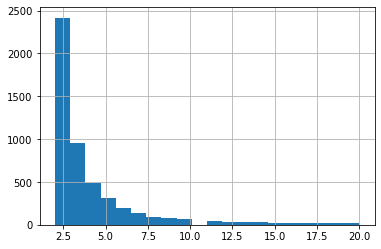

In [9]:
context_length.hist(bins = 20)

In [10]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(train_data['label'])

In [11]:
X = train_data['response'] + ' ' + train_data['context'].str.join(' ')

In [12]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [13]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [14]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn),
          'precision': 'precision',
          'recall': 'recall',
          'f1': 'f1'}
res = cross_validate(text_clf, X, y, cv=skf, n_jobs=5, scoring=scoring)

In [15]:
res

{'fit_time': array([0.36322999, 0.36468983, 0.36570287, 0.37889481, 0.36366105]),
 'score_time': array([0.08974624, 0.08730531, 0.08717227, 0.08364105, 0.08646512]),
 'test_tp': array([378, 387, 385, 386, 416]),
 'test_tn': array([360, 381, 345, 348, 361]),
 'test_fp': array([140, 119, 155, 152, 139]),
 'test_fn': array([122, 113, 115, 114,  84]),
 'test_precision': array([0.72972973, 0.76482213, 0.71296296, 0.71747212, 0.74954955]),
 'test_recall': array([0.756, 0.774, 0.77 , 0.772, 0.832]),
 'test_f1': array([0.74263261, 0.7693837 , 0.74038462, 0.74373796, 0.78862559])}

In [16]:
print('Macro Avg precision: {}, recall {}, F1 score {}'.format(np.average(res['test_precision']), np.average(res['test_recall']), np.average(res['test_f1'])))

Macro Avg precision: 0.7349072991177403, recall 0.7807999999999999, F1 score 0.7569528952384379


In [17]:
final_model = text_clf.fit(X, y)
test_res = final_model.predict(test_data['response'] + ' ' + test_data['context'].str.join(' '))

In [18]:
result_df = pd.DataFrame()
result_df['id'] = test_data['id']
result_df['result'] = pd.Series(le.inverse_transform(test_res))

In [19]:
result_df.head()

,id,result
0,twitter_1,NOT_SARCASM
1,twitter_2,SARCASM
2,twitter_3,NOT_SARCASM
3,twitter_4,NOT_SARCASM
4,twitter_5,SARCASM


In [20]:
with open('answer.txt', 'w') as f:
    result_df.to_csv(f, header=False, index=False)

In [21]:
result_df['result'].value_counts()

SARCASM        904
NOT_SARCASM    896
Name: result, dtype: int64

In [22]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
text_clf2 = Pipeline([
    ('vect', CountVectorizer(strip_accents = 'unicode',
                       stop_words = 'english',
                       lowercase = True)),
    ('tfidf', TfidfTransformer()),
    ('clf', GradientBoostingClassifier()),
])
res2 = cross_validate(text_clf2, X, y, cv=skf, n_jobs=5, scoring=scoring)

In [24]:
res2

{'fit_time': array([4.8076632 , 4.79586315, 4.77715111, 4.84718108, 4.78924918]),
 'score_time': array([0.12416482, 0.12808394, 0.12694287, 0.12094998, 0.12623501]),
 'test_tp': array([378, 384, 388, 400, 392]),
 'test_tn': array([283, 301, 299, 295, 319]),
 'test_fp': array([217, 199, 201, 205, 181]),
 'test_fn': array([122, 116, 112, 100, 108]),
 'test_precision': array([0.63529412, 0.65866209, 0.65874363, 0.66115702, 0.68411867]),
 'test_recall': array([0.756, 0.768, 0.776, 0.8  , 0.784]),
 'test_f1': array([0.69041096, 0.70914127, 0.71258035, 0.7239819 , 0.7306617 ])}

In [25]:
print('Macro Avg precision: {}, recall {}, F1 score {}'.format(np.average(res2['test_precision']), np.average(res2['test_recall']), np.average(res2['test_f1'])))

Macro Avg precision: 0.6595951083978028, recall 0.7767999999999999, F1 score 0.7133552357435496


In [26]:
print('Macro Avg precision: {}, recall {}, F1 score {}'.format(np.average(res2['test_precision']), np.average(res2['test_recall']), np.average(res2['test_f1'])))

Macro Avg precision: 0.6595951083978028, recall 0.7767999999999999, F1 score 0.7133552357435496


In [27]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
text_clf2 = Pipeline([
    ('vect', CountVectorizer(strip_accents = 'unicode',
                       stop_words = 'english',
                       lowercase = True)),
    ('tfidf', TfidfTransformer()),
    ('clf', GradientBoostingClassifier()),
])
res2 = cross_validate(text_clf2, X, y, cv=skf, n_jobs=5, scoring=scoring)

In [28]:
res2

{'fit_time': array([4.97709894, 4.9373889 , 4.94328904, 4.9892199 , 4.9449892 ]),
 'score_time': array([0.13985205, 0.14647508, 0.14524007, 0.14320922, 0.14607167]),
 'test_tp': array([377, 378, 382, 400, 399]),
 'test_tn': array([278, 302, 293, 295, 311]),
 'test_fp': array([222, 198, 207, 205, 189]),
 'test_fn': array([123, 122, 118, 100, 101]),
 'test_precision': array([0.6293823 , 0.65625   , 0.64855688, 0.66115702, 0.67857143]),
 'test_recall': array([0.754, 0.756, 0.764, 0.8  , 0.798]),
 'test_f1': array([0.68607825, 0.70260223, 0.70156107, 0.7239819 , 0.73345588])}

In [29]:
print('Macro Avg precision: {}, recall {}, F1 score {}'.format(np.average(res2['test_precision']), np.average(res2['test_recall']), np.average(res2['test_f1'])))

Macro Avg precision: 0.6547835266531342, recall 0.7744, F1 score 0.7095358662886728


In [62]:
automl = Pipeline([
    ('vect', CountVectorizer(strip_accents = 'unicode',
                       stop_words = 'english',
                       lowercase = True)),
    ('tfidf', TfidfTransformer()),
    ('clf', AutoSklearnClassifier(
        time_left_for_this_task=3600,
        memory_limit=24576,
        tmp_folder='/Users/astrok/tmp/autosklearn_classification/sarcasm/tmp/',
        output_folder='/Users/astrok/tmp/autosklearn_classification/sarcasm/out/',
        include_preprocessors=["no_preprocessing", ],
        resampling_strategy='cv',
        resampling_strategy_arguments={'folds': 5},
        n_jobs=-1,
    )),
])
automl.fit(X, y)

/Users/astrok/opt/anaconda3/envs/py37/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54305 instead
  http_address["port"], self.http_server.port


[WARNING] [2020-11-29 16:39:41,852:AutoML(1):b3e75eddc9e5d37a77c4c778416dd791] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (3599.634847)
[WARNING] [2020-11-29 16:39:41,854:AutoML(1):b3e75eddc9e5d37a77c4c778416dd791] Capping the per_run_time_limit to 1799.0 to have time for a least 2 models in each process.


/Users/astrok/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents='unicode',
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, voca...
                                       metadata_directory=None, metric=None,
                                       n_jobs=-1,
                                       output_folder='/Users/astrok/tmp/autosklearn_classification/sarcasm/out/',
                                       per_run_time_limit=5760,
                               

In [101]:
cv_res = pd.DataFrame(automl.steps[2][1].cv_results_)

In [102]:
cv_res.sort_values('mean_test_score', ascending=False)

,mean_test_score,mean_fit_time,params,rank_test_scores,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessing:categorical_transformer:categorical_encoding:__choice__,param_data_preprocessing:categorical_transformer:category_coalescence:__choice__,...,param_data_preprocessing:numerical_transformer:rescaling:quantile_transformer:n_quantiles,param_data_preprocessing:numerical_transformer:rescaling:quantile_transformer:output_distribution,param_data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_min,param_classifier:libsvm_svc:coef0,param_classifier:libsvm_svc:degree,param_classifier:sgd:epsilon,param_classifier:sgd:eta0,param_classifier:sgd:l1_ratio,param_classifier:sgd:power_t
497,0.776970,24.727731,"{'balancing:strategy': 'none', 'classifier:__c...",1,Success,0.0,none,libsvm_svc,one_hot_encoding,minority_coalescer,...,NaN,NaN,0.718487,0.290044,0.036325,2.0,NaN,NaN,NaN,NaN
453,0.776364,20.545186,"{'balancing:strategy': 'none', 'classifier:__c...",2,Success,0.0,none,libsvm_svc,no_encoding,minority_coalescer,...,NaN,NaN,0.957425,0.145949,0.046125,2.0,NaN,NaN,NaN,NaN
248,0.776364,21.247054,"{'balancing:strategy': 'none', 'classifier:__c...",2,Success,0.0,none,libsvm_svc,no_encoding,no_coalescense,...,NaN,NaN,NaN,NaN,0.031333,2.0,NaN,NaN,NaN,NaN
375,0.776364,25.223575,"{'balancing:strategy': 'none', 'classifier:__c...",2,Success,0.0,none,libsvm_svc,no_encoding,no_coalescense,...,NaN,NaN,0.736314,0.264820,0.038469,2.0,NaN,NaN,NaN,NaN
407,0.776364,18.340470,"{'balancing:strategy': 'weighting', 'classifie...",2,Success,0.0,weighting,libsvm_svc,no_encoding,minority_coalescer,...,NaN,NaN,0.727951,0.265031,0.038771,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,0.000000,424.021845,"{'balancing:strategy': 'weighting', 'classifie...",548,Timeout,0.0,weighting,extra_trees,one_hot_encoding,minority_coalescer,...,1550.0,uniform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
553,0.000000,22.017314,"{'balancing:strategy': 'none', 'classifier:__c...",548,Timeout,0.0,none,libsvm_svc,no_encoding,no_coalescense,...,NaN,NaN,NaN,NaN,-0.001478,3.0,NaN,NaN,NaN,NaN
554,0.000000,13.013409,"{'balancing:strategy': 'none', 'classifier:__c...",548,Timeout,0.0,none,libsvm_svc,one_hot_encoding,minority_coalescer,...,NaN,NaN,0.716937,0.293125,0.065918,2.0,NaN,NaN,NaN,NaN
555,0.000000,12.028406,"{'balancing:strategy': 'weighting', 'classifie...",548,Timeout,0.0,weighting,sgd,one_hot_encoding,minority_coalescer,...,NaN,NaN,0.904689,0.183092,NaN,NaN,NaN,NaN,0.000965,NaN


In [103]:
res_norm = pd.json_normalize(cv_res['params'], max_level=0)

In [104]:
res_norm.head()

,balancing:strategy,classifier:__choice__,data_preprocessing:categorical_transformer:categorical_encoding:__choice__,data_preprocessing:categorical_transformer:category_coalescence:__choice__,data_preprocessing:numerical_transformer:imputation:strategy,data_preprocessing:numerical_transformer:rescaling:__choice__,feature_preprocessor:__choice__,classifier:random_forest:bootstrap,classifier:random_forest:criterion,classifier:random_forest:max_depth,...,classifier:sgd:average,classifier:sgd:fit_intercept,classifier:sgd:learning_rate,classifier:sgd:loss,classifier:sgd:penalty,classifier:sgd:tol,classifier:sgd:epsilon,classifier:sgd:l1_ratio,classifier:sgd:eta0,classifier:sgd:power_t
0,none,random_forest,one_hot_encoding,minority_coalescer,mean,standardize,no_preprocessing,True,gini,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,weighting,random_forest,one_hot_encoding,no_coalescense,most_frequent,quantile_transformer,no_preprocessing,False,entropy,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,none,random_forest,one_hot_encoding,minority_coalescer,mean,standardize,no_preprocessing,False,gini,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,none,random_forest,one_hot_encoding,no_coalescense,most_frequent,standardize,no_preprocessing,False,gini,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,weighting,extra_trees,one_hot_encoding,minority_coalescer,median,standardize,no_preprocessing,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
res = pd.concat([cv_res['mean_test_score'], res_norm], axis=1)
res.sort_values('mean_test_score', ascending=False)

,mean_test_score,balancing:strategy,classifier:__choice__,data_preprocessing:categorical_transformer:categorical_encoding:__choice__,data_preprocessing:categorical_transformer:category_coalescence:__choice__,data_preprocessing:numerical_transformer:imputation:strategy,data_preprocessing:numerical_transformer:rescaling:__choice__,feature_preprocessor:__choice__,classifier:random_forest:bootstrap,classifier:random_forest:criterion,...,classifier:sgd:average,classifier:sgd:fit_intercept,classifier:sgd:learning_rate,classifier:sgd:loss,classifier:sgd:penalty,classifier:sgd:tol,classifier:sgd:epsilon,classifier:sgd:l1_ratio,classifier:sgd:eta0,classifier:sgd:power_t
497,0.776970,none,libsvm_svc,one_hot_encoding,minority_coalescer,median,robust_scaler,no_preprocessing,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,0.776364,none,libsvm_svc,no_encoding,minority_coalescer,mean,robust_scaler,no_preprocessing,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,0.776364,none,libsvm_svc,no_encoding,no_coalescense,most_frequent,none,no_preprocessing,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
375,0.776364,none,libsvm_svc,no_encoding,no_coalescense,most_frequent,robust_scaler,no_preprocessing,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407,0.776364,weighting,libsvm_svc,no_encoding,minority_coalescer,mean,robust_scaler,no_preprocessing,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,0.000000,weighting,extra_trees,one_hot_encoding,minority_coalescer,mean,quantile_transformer,no_preprocessing,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
553,0.000000,none,libsvm_svc,no_encoding,no_coalescense,most_frequent,none,no_preprocessing,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
554,0.000000,none,libsvm_svc,one_hot_encoding,minority_coalescer,most_frequent,robust_scaler,no_preprocessing,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
555,0.000000,weighting,sgd,one_hot_encoding,minority_coalescer,most_frequent,robust_scaler,no_preprocessing,NaN,NaN,...,False,True,optimal,squared_hinge,elasticnet,0.000098,NaN,0.000965,NaN,NaN


In [108]:
res.to_csv('1.csv')